# Plot Error Distribution

In [2]:
import seaborn as sns
import json
import pandas as pd

# To Reload the data
#!rm -Rf processed-evaluation-results.json

dfs = load_preprocessed_reconstruction_or_from_cache()

def load_errors(approach, corpus, normalized):
    ret = df[(df['Approach'] == approach) & (df['Corpus'] == corpus)]
    if len(ret) != 1:
        raise ValueError('TBD')
    
    ret = ret.iloc[0].to_dict()
    
    if normalized:
        return ret['Errors (Normalized)']
    else:
        return ret['Errors']
    

out = {'Condensed': {}, 'PBS-RP-ML': {}}

for k in list(out.keys()):
    out[k] = {
        'Robust04': load_errors(k, 'Robust04', False),
        'Robust04 (Normalized)': load_errors(k, 'Robust04', True),

        'CW09': load_errors(k, 'CW09', False),
        'CW09 (Normalized)': load_errors(k, 'CW09', True),

        'CW12': load_errors(k, 'CW12', False),
        'CW12 (Normalized)': load_errors(k, 'CW12', True),
    }
    
json.dump(out, open('tmp-errors.json', 'w'))

def load_error_df(normalized=True):
    df_errors = []
    errors = json.load(open('tmp-errors.json', 'r'))

    for k in errors.keys():
        for corpus in errors[k].keys():
            if normalized and 'normalized' in corpus.lower():
                for err in errors[k][corpus]:
                    df_errors += [{'Error': err, 'Corpus': corpus.split()[0], 'Normalized': normalized, 'Prediction': k}]
            elif not normalized and 'normalized' not in corpus.lower():
                for err in errors[k][corpus]:
                    df_errors += [{'Error': err, 'Corpus': corpus.split()[0], 'Normalized': normalized, 'Prediction': k}]
    
    return pd.DataFrame(df_errors)

In [3]:
load_error_df(False).describe()

,Error
count,23372.000000
mean,-0.011256
std,0.069784
min,-0.576669
25%,-0.028821
50%,0.000000
75%,0.000000
max,0.441361


In [4]:
load_error_df(True).describe()

,Error
count,23372.000000
mean,-0.304321
std,0.588530
min,-1.000000
25%,-1.000000
50%,0.000000
75%,0.000000
max,1.000000


In [12]:
pd.concat([load_error_df(True), load_error_df(False)])

,Error,Corpus,Normalized,Prediction
0,0.000000e+00,Robust04,True,Condensed
1,0.000000e+00,Robust04,True,Condensed
2,0.000000e+00,Robust04,True,Condensed
3,0.000000e+00,Robust04,True,Condensed
4,0.000000e+00,Robust04,True,Condensed
...,...,...,...,...
23367,-2.256324e-02,CW12,False,PBS-RP-ML
23368,8.245859e-04,CW12,False,PBS-RP-ML
23369,1.081944e-03,CW12,False,PBS-RP-ML
23370,-4.190803e-11,CW12,False,PBS-RP-ML


/mnt/ceph/storage/data-tmp/current/kibi9872/ecir23-incomplete-judgments/.venv/lib/python3.8/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

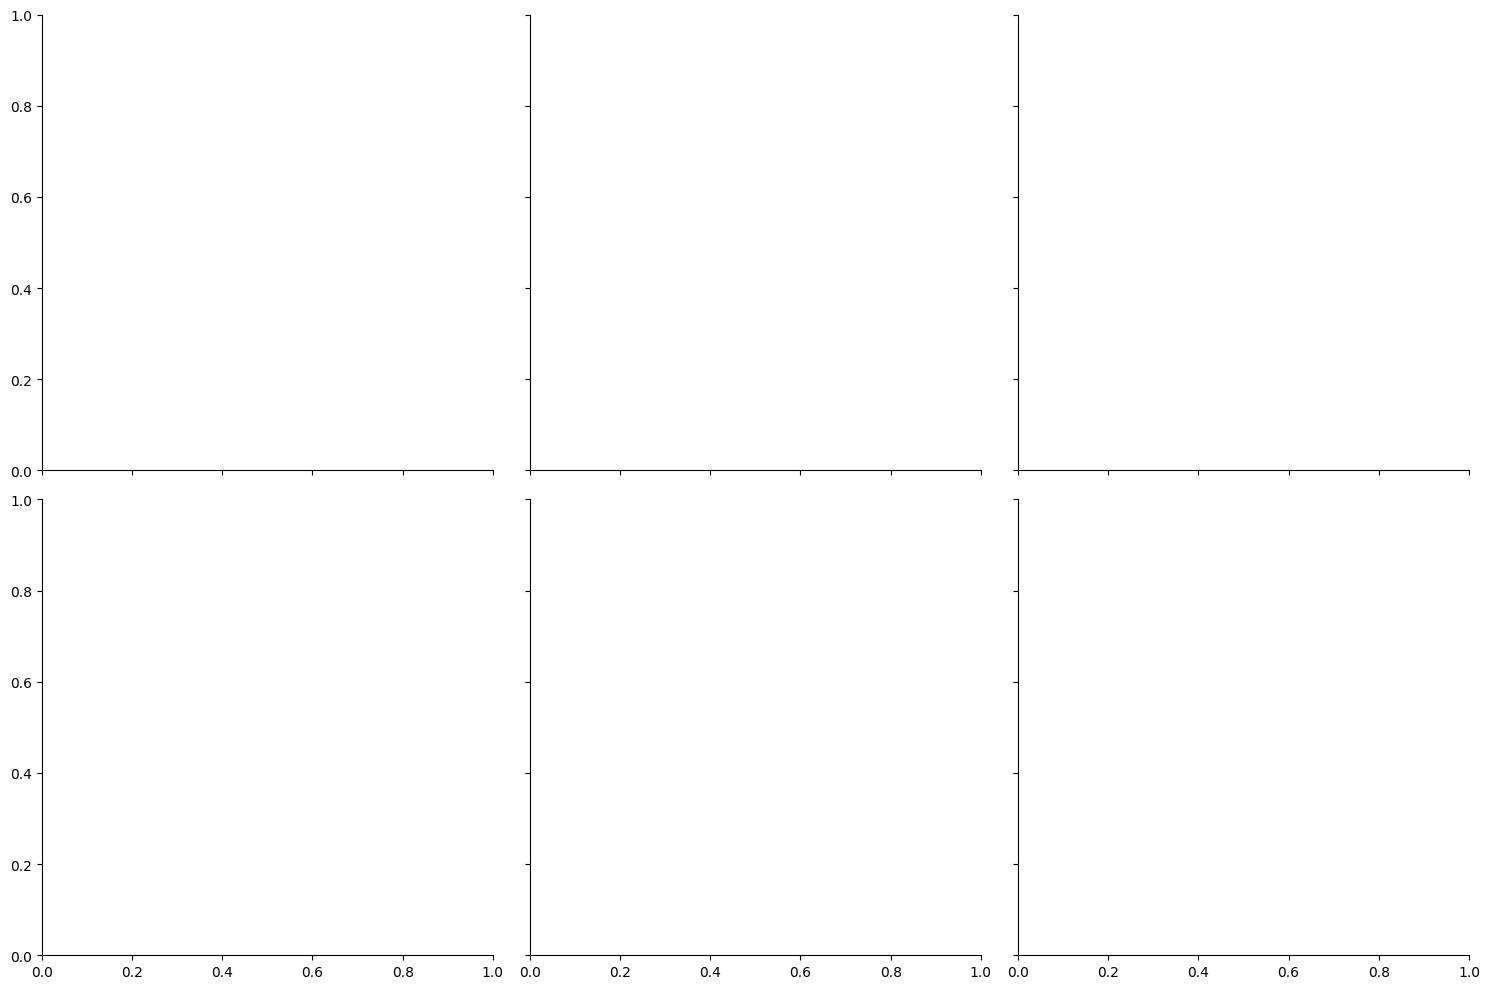

In [13]:
sns.displot(data=pd.concat([load_error_df(True), load_error_df(False)]), x='Error', col='Corpus', hue='Prediction', kind='kde', row='Normalized')

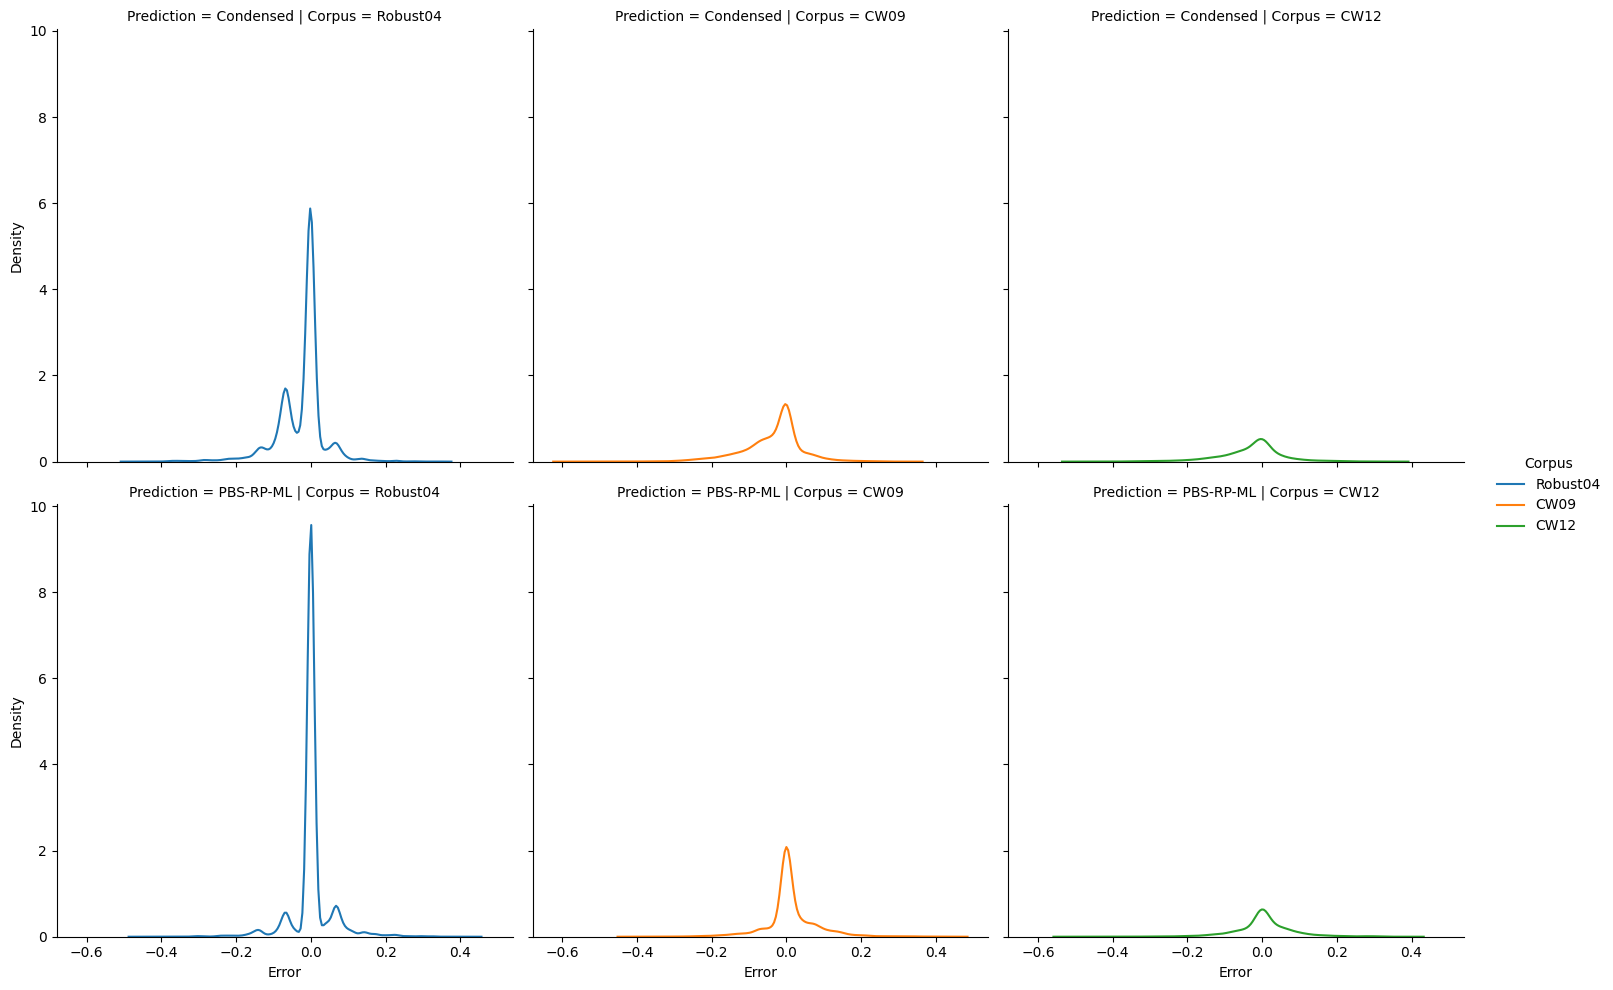

In [7]:
sns.displot(data=load_error_df(False), x='Error', col='Corpus', hue='Corpus', kind='kde', row='Prediction')

In [8]:
def normaltest(x, alpha = 1e-3):
    from scipy import stats
    _, p = stats.normaltest(x)
    
    if p < alpha:
        print('The null hypothesis that x comes from a normal distribution can be rejected')
    else:
        print("The null hypothesis that x comes from a normal distribution cannot be rejected")

    return p

for method in ['PBS-RP-ML', 'Condensed']:
    for normalization in [True, False]:
        df = load_error_df()
        print('#'*50)
        print(method + ' With ' + ('normalization' if normalization else 'no normalization'))
        
        for corpus in ['Robust04', 'CW09', 'CW12']:
            print(normaltest(list(df[(df['Corpus'] == corpus) & (df['Prediction'] == method)]['Error'])))
        
        print('\n\n' + '#'*50)


##################################################
PBS-RP-ML With normalization
The null hypothesis that x comes from a normal distribution can be rejected
1.4002112542235747e-156
The null hypothesis that x comes from a normal distribution can be rejected
6.740039623493276e-128
The null hypothesis that x comes from a normal distribution can be rejected
4.921828670006092e-31


##################################################
##################################################
PBS-RP-ML With no normalization
The null hypothesis that x comes from a normal distribution can be rejected
1.4002112542235747e-156
The null hypothesis that x comes from a normal distribution can be rejected
6.740039623493276e-128
The null hypothesis that x comes from a normal distribution can be rejected
4.921828670006092e-31


##################################################
##################################################
Condensed With normalization
The null hypothesis that x comes from a normal distributi